In [1]:
%matplotlib inline

import gc
import itertools
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import seaborn
import sys

pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['agg.path.chunksize'] = 10000
print(f'Package versions:\nPython {sys.version}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'seaborn {seaborn.__version__}')

Package versions:
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], matplotlib 3.4.2, numpy 1.21.0, pandas 1.1.5, seaborn 0.11.1


## Make barplot

In [3]:
drop_dups = pandas.read_csv('./read_dataframe.csv')
print(drop_dups.shape)
drop_dups.head()

(10331759, 10)


,well_id,r1,seq_corr,edit_type,umi,het_spacer_offset,bc1_corr,bc2_corr,condition,read_count
0,A1,ACGATCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTC...,TCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTCCT,WT,GGTTTCTGTT,4,ACAAGCTA,TGCGGCGC,bc1_10h_rep1,1
1,A1,GATCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTC...,TCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTCCT,WT,GTTATGTTCT,2,AGATCGCA,CCTGACGT,bc1_24h_rep1,1
2,A1,GAGAGATCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCAC...,TCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCACTCTCCT,Mutant,GTCACACAAT,6,AAGATTCG,GCCGTGAA,bc1_72h_rep2,1
3,A1,GATCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTC...,TCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTCCT,WT,TCGTACCAAT,2,CGCATACA,CCGCATGT,bc1_24h_rep3,1
4,A1,CGATCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCACTCT...,TCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCACTCTCCT,Mutant,CAGGTTCATA,3,UNKNOWN,UNKNOWN,UNKNOWN,1


In [4]:
all_stats = drop_dups.groupby('edit_type')['read_count'].sum()
all_stats['TOTAL'] = all_stats.sum()
all_stats = all_stats.reset_index().sort_values(by='read_count', ascending=False)
all_stats

,edit_type,read_count
3,TOTAL,11554749
2,WT,9499525
1,UNKNOWN,1133956
0,Mutant,921268


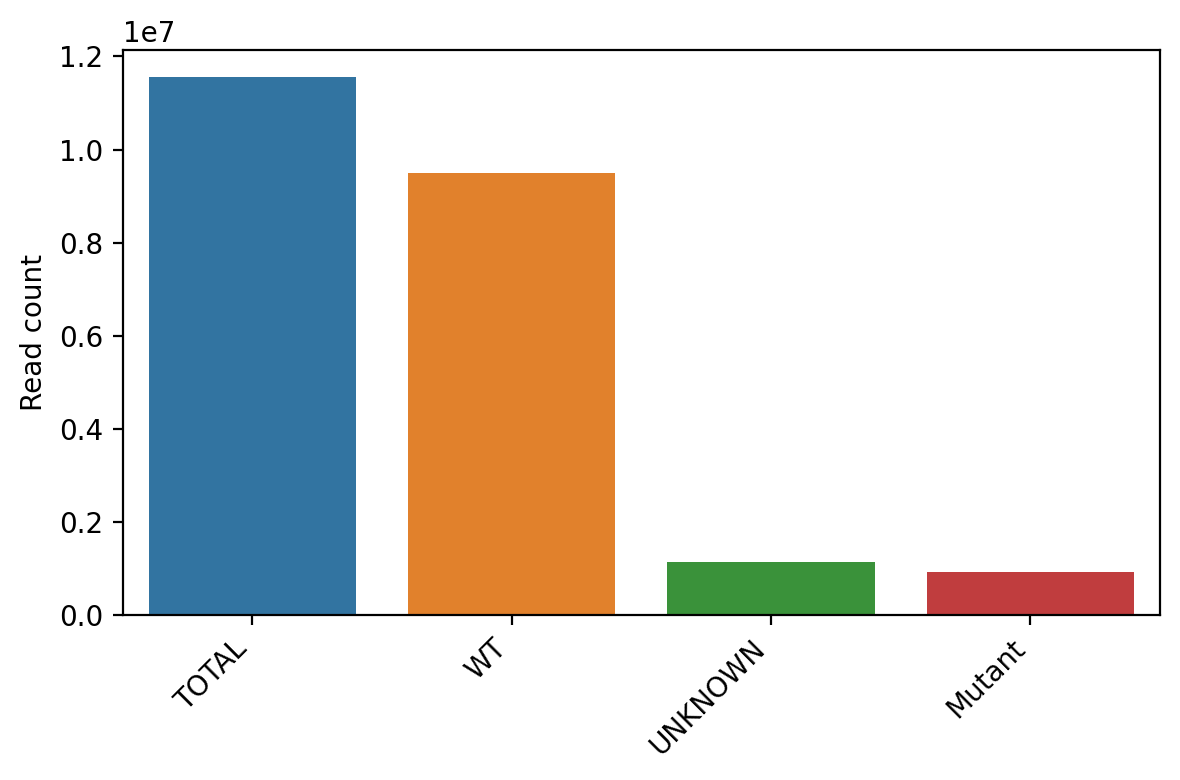

In [5]:
#plot read 1 matches
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
seaborn.barplot(data=all_stats, x='edit_type', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes.set_xlabel('')
axes.set_ylabel('Read count')
fig.tight_layout()

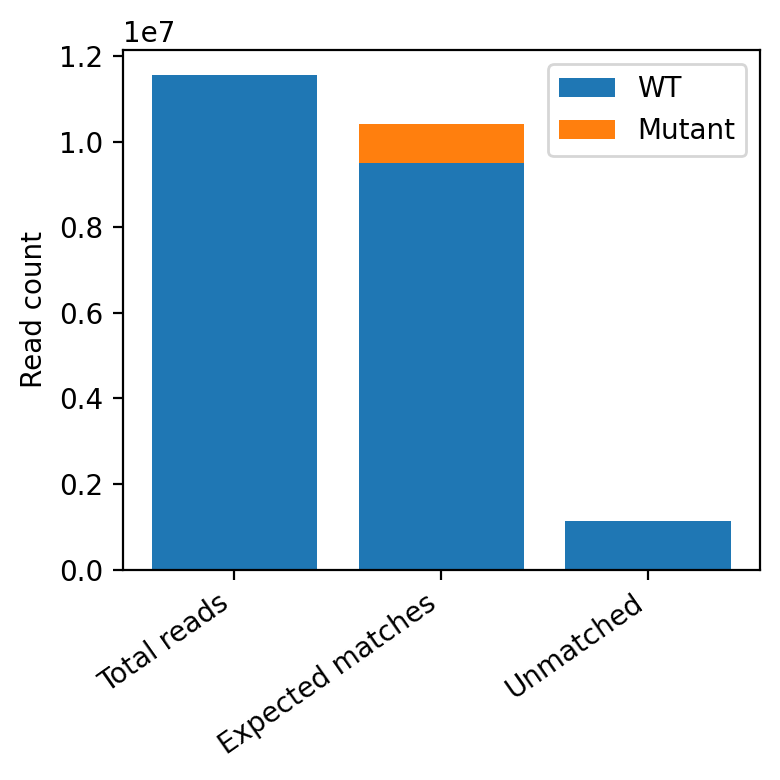

In [6]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(4,4))
axes.bar(x=0, height=all_stats.loc[all_stats['edit_type'] == 'TOTAL', 'read_count'], color='C0')

stacked_indices = ~all_stats['edit_type'].isin(['UNKNOWN', 'TOTAL'])
bottom=0
for r1_name, val in all_stats.loc[stacked_indices, ['edit_type', 'read_count']].to_numpy():
    axes.bar(x=1, height=val, bottom=bottom, label=r1_name)
    bottom += val

axes.bar(x=2, height=all_stats.loc[all_stats['edit_type'] == 'UNKNOWN', 'read_count'], color='C0')

axes.set_xticks(numpy.arange(3))
axes.set_xticklabels(['Total reads', 'Expected matches', 'Unmatched'], ha='right', rotation=35)
axes.set_ylabel('Read count')
axes.legend(bbox_to_anchor=[1,1])
fig.tight_layout()

In [7]:
##NOTE: These numbers from the pipeline do not yet reflect the reads where a barcode is detected, but not an edit type
#       (r1_type). So, the UNKNOWN count is inflated and all barcode counts are slightly less than they should be. This
#       will be fixed in a future version of the pipeline.
all_stats = drop_dups.groupby('condition')['read_count'].sum()
all_stats['TOTAL'] = all_stats.sum()
order = ['TOTAL', 'UNKNOWN'] + sorted(all_stats.loc[~all_stats.index.isin(['TOTAL', 'UNKNOWN'])].index.values)
all_stats = all_stats.loc[order].rename('read_count').reset_index()
all_stats

,condition,read_count
0,TOTAL,11554749
1,UNKNOWN,1404208
2,bc1_10h_rep1,1800035
3,bc1_10h_rep2,1226285
4,bc1_10h_rep3,2012763
5,bc1_24h_rep1,787449
6,bc1_24h_rep2,817596
7,bc1_24h_rep3,1112784
8,bc1_72h_rep1,392637
9,bc1_72h_rep2,544377


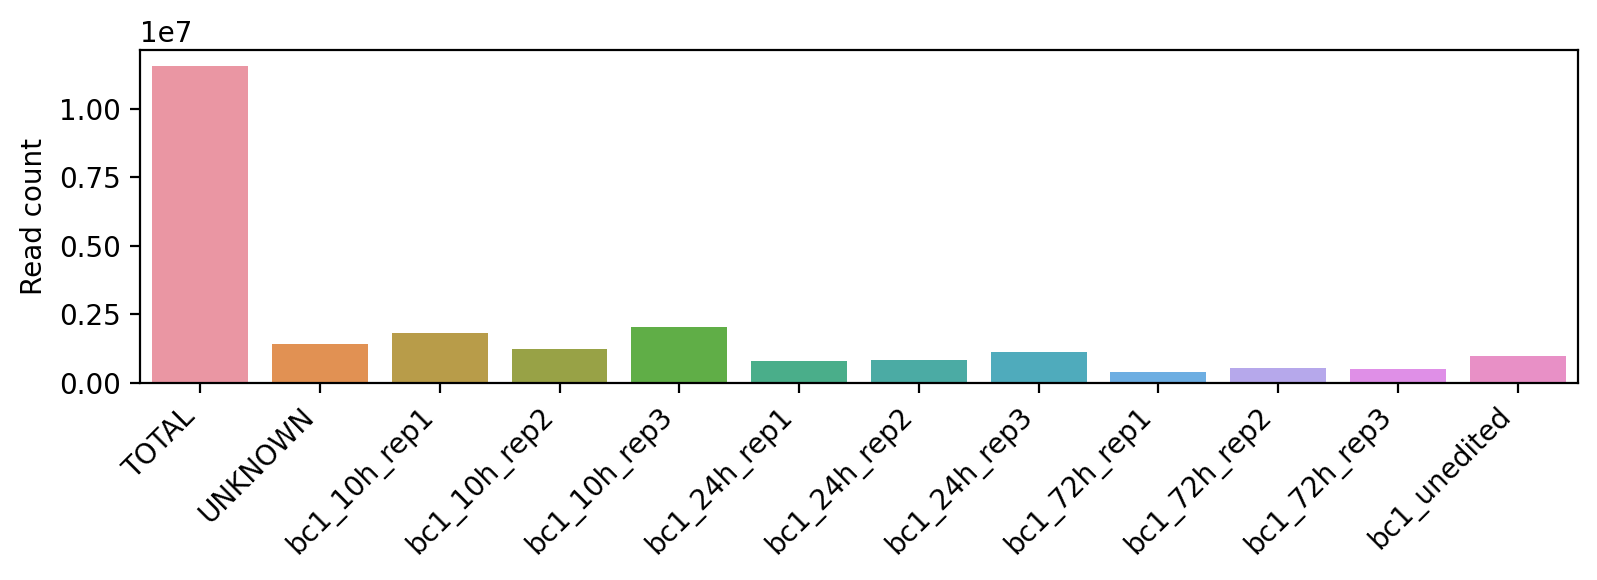

In [8]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,3))
seaborn.barplot(data=all_stats, x='condition', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right', fontsize=10)
axes.set_xlabel('')
axes.set_ylabel('Read count')
fig.tight_layout()

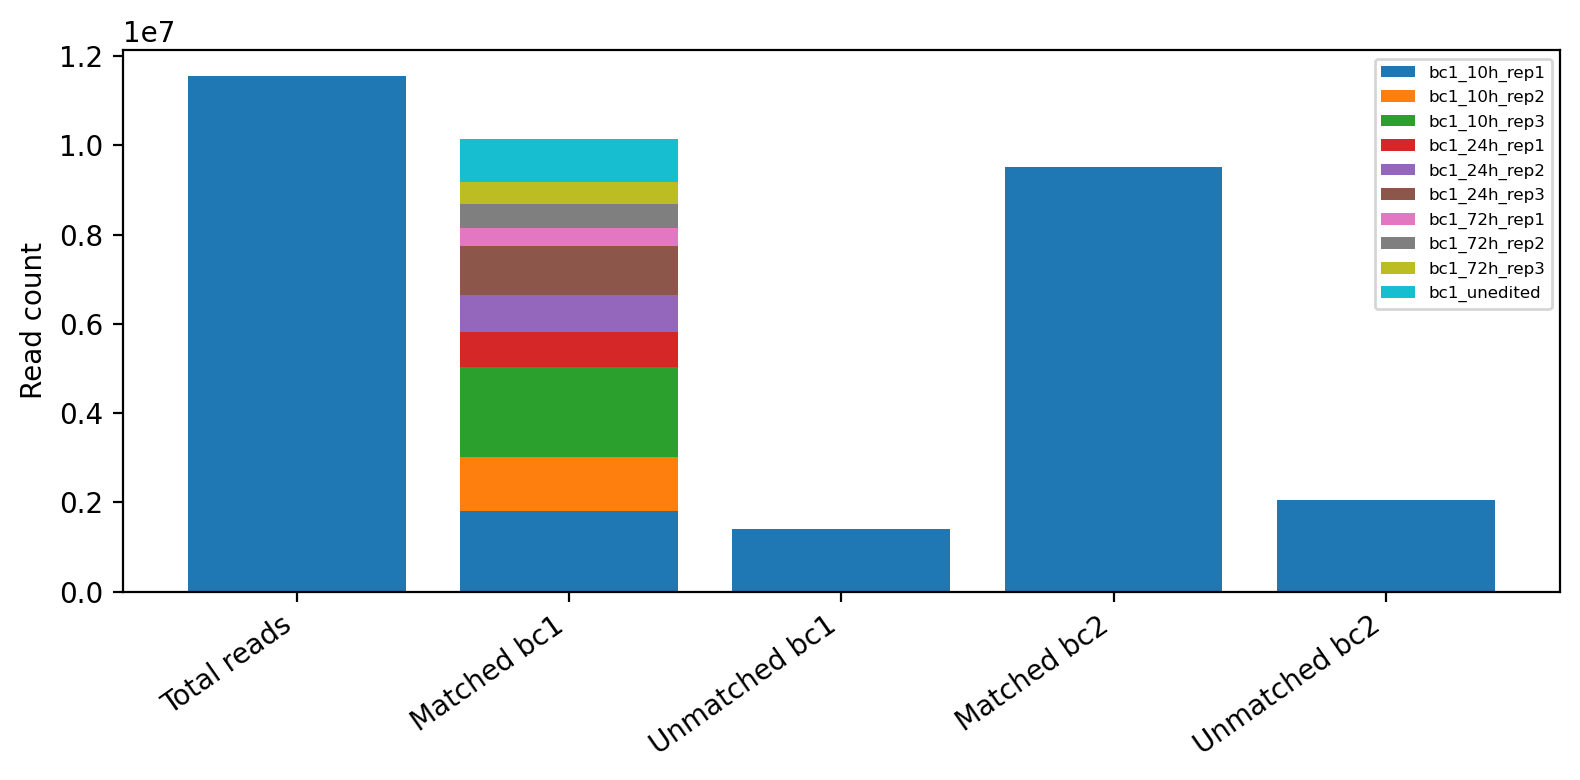

In [9]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,4))
axes.bar(x=0, height=all_stats.loc[all_stats['condition'] == 'TOTAL', 'read_count'], color='C0')

stacked_indices = ~all_stats['condition'].isin(['UNKNOWN', 'TOTAL'])
bottom=0
for r1_name, val in all_stats.loc[stacked_indices].to_numpy():
    axes.bar(x=1, height=val, bottom=bottom, label=r1_name)
    bottom += val

axes.bar(x=2, height=all_stats.loc[all_stats['condition'] == 'UNKNOWN', 'read_count'], color='C0')

axes.bar(x=3, height=drop_dups.loc[drop_dups['bc2_corr'] != 'UNKNOWN', 'read_count'].sum(), color='C0')
axes.bar(x=4, height=drop_dups.loc[drop_dups['bc2_corr'] == 'UNKNOWN', 'read_count'].sum(), color='C0')

axes.set_xticks(numpy.arange(5))
axes.set_xticklabels(['Total reads', 'Matched bc1', 'Unmatched bc1', 
                      'Matched bc2', 'Unmatched bc2'], ha='right', rotation=35)
axes.set_ylabel('Read count')
axes.legend(bbox_to_anchor=[1,1], fontsize=6)
fig.tight_layout()

In [10]:
interpretable_idx = ((drop_dups['edit_type'] != 'UNKNOWN') 
                     & (drop_dups['condition'] != 'UNKNOWN') 
                     & (drop_dups['bc2_corr'] != 'UNKNOWN'))
print(f'Overall interpretable reads: {drop_dups.loc[interpretable_idx, "read_count"].sum()} '
      f'({round((drop_dups.loc[interpretable_idx, "read_count"].sum()/drop_dups["read_count"].sum())*100, 2)} %)')

Overall interpretable reads: 9274159 (80.26 %)


In [11]:
correct_bc_idx = ((drop_dups['condition'] != 'UNKNOWN')
                  & (drop_dups['bc2_corr'] != 'UNKNOWN'))
print(f'Overall reads with interpretable barcodes: {drop_dups.loc[correct_bc_idx, "read_count"].sum()} '
      f'({round((drop_dups.loc[correct_bc_idx, "read_count"].sum()/drop_dups["read_count"].sum())*100, 2)} %)')
correct_bc_and_unk_num = drop_dups.loc[(drop_dups['edit_type'] == 'UNKNOWN') & correct_bc_idx, 'read_count'].sum()
print(f'Of these, {correct_bc_and_unk_num} ({round((correct_bc_and_unk_num/drop_dups.loc[correct_bc_idx, "read_count"].sum())*100, 2)} %) '
      'reads have interpretable barcodes, but unknown read 1 sequences.')

Overall reads with interpretable barcodes: 9365725 (81.06 %)
Of these, 91566 (0.98 %) reads have interpretable barcodes, but unknown read 1 sequences.


## Plot cell data

In [22]:
valid_cells = pandas.read_csv('./heteroplasmy_dataframe.csv')
valid_cells.columns = valid_cells.columns.str.replace('_HET', '_het')
print(valid_cells.shape)
valid_cells.head()

(12894, 8)


,cell_id,condition,umi_count,Mutant,WT,umi_count_for_filtering,umi_count_rank,Mutant_het
0,A2-CTGTAGCC-TGCGGCGC,bc1_10h_rep1,485,0,485,485,164,0.000000
1,A2-ACCACTGT-GCATTCTA,bc1_unedited,299,0,299,299,725,0.000000
2,A2-AAGACGGA-GTTGCTGT,bc1_10h_rep2,594,0,594,594,78,0.000000
3,A2-AGAGTCAA-GTCATCCA,bc1_10h_rep3,397,1,396,397,334,0.002519
4,A2-CATACCAA-CGTCAGTG,bc1_24h_rep2,438,0,438,438,250,0.000000


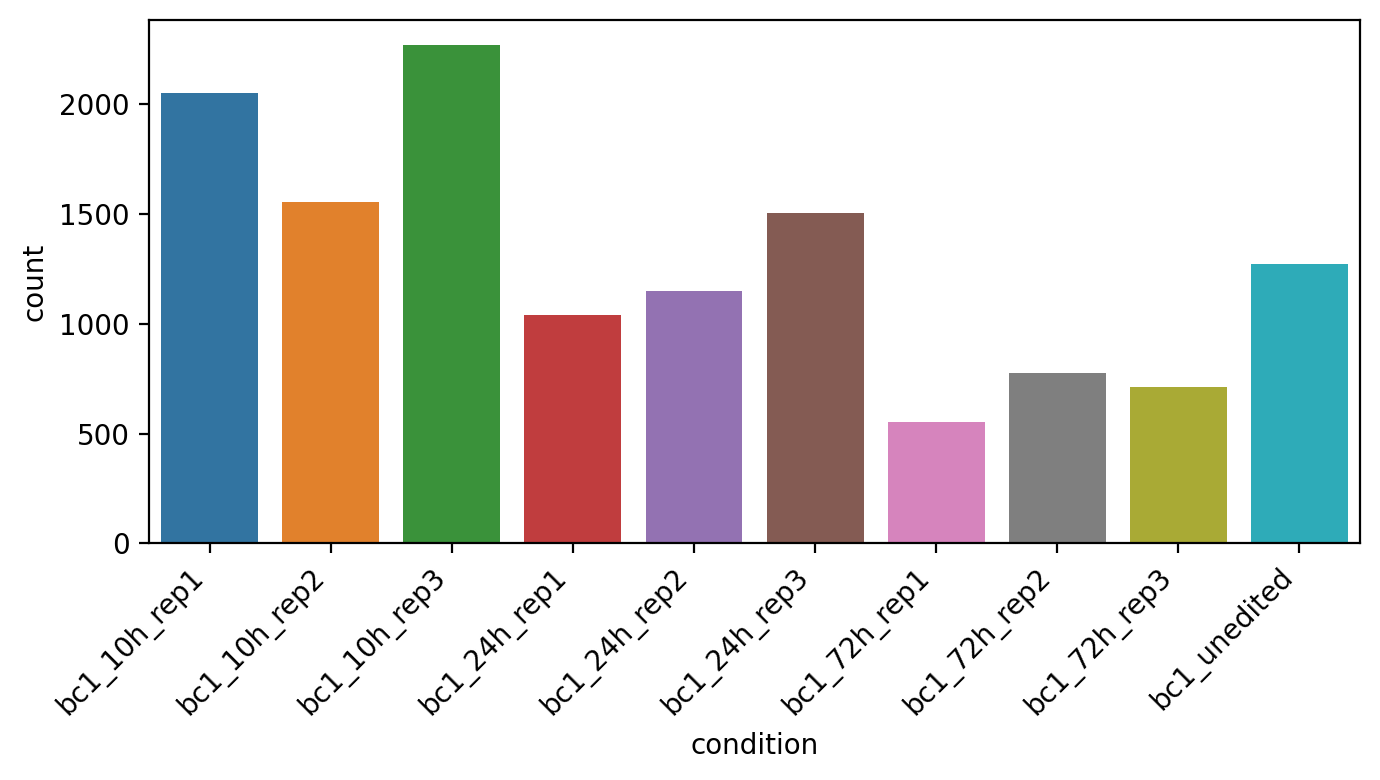

In [24]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,4))
xorder = sorted(valid_cells['condition'].unique())
seaborn.countplot(data=valid_cells, x='condition', order=xorder, ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
fig.tight_layout()

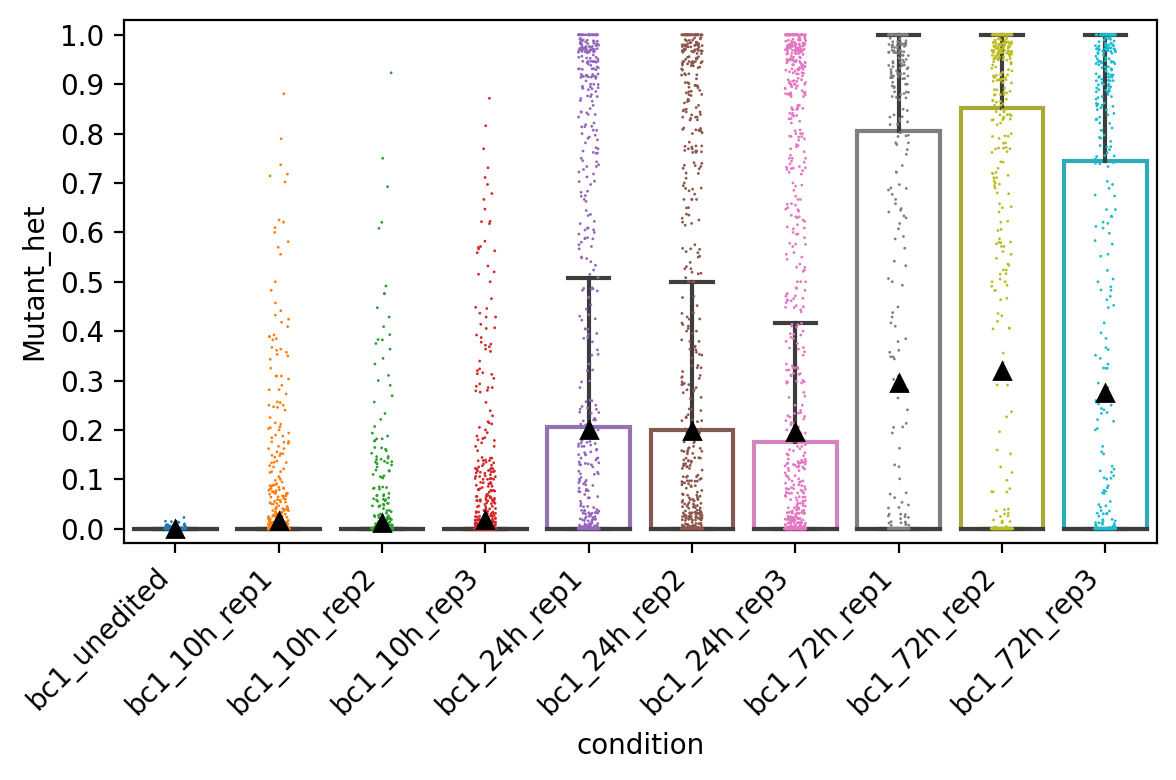

In [25]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
#xorder = bc1_list.loc[bc1_list['condition'].isin(valid_cells['condition']), 'condition'].unique()
xorder = sorted(valid_cells['condition'].unique(), key=lambda x:(0,0) if 'unedited' in x else (int(x.split('_')[1][:2]), x.split('_')[2]))
seaborn.boxplot(data=valid_cells, x='condition', y='Mutant_het', ax=axes, order=xorder, showfliers=False)
seaborn.stripplot(data=valid_cells, x='condition', y='Mutant_het', dodge=True, s=1, order=xorder, ax=axes)
axes.plot(numpy.arange(len(xorder)), valid_cells.groupby('condition')['Mutant_het'].mean()[xorder],
          color='k', marker='^', linestyle='', zorder=100, label='mean het estimate')

for patch in axes.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0))
    patch.set_edgecolor((r, g, b, 1))
    
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_ylim((-0.03, 1.03))
axes.set_yticks(numpy.arange(0, 1.1, 0.1))

fig.tight_layout()

In [27]:
valid_cells['condition_norep'] = [elt.split('_rep')[0] for elt in valid_cells['condition'].values]
valid_cells.groupby('condition_norep')['Mutant_het'].mean()

condition_norep
bc1_10h         0.014734
bc1_24h         0.197121
bc1_72h         0.296869
bc1_unedited    0.000139
Name: Mutant_het, dtype: float64

In [28]:
test = pandas.concat([valid_cells[valid_cells['Mutant_het'] <= 0.2].groupby('condition_norep').size().rename('le20'),
                      valid_cells[valid_cells['Mutant_het'] > 0.2].groupby('condition_norep').size().rename('gt20')],
                     axis=1)
test[['frac_le20', 'frac_gt20']] = test.fillna(0).values/test.fillna(0).values.sum(axis=1)[:,None]
test

,le20,gt20,frac_le20,frac_gt20
bc1_10h,5740,141.0,0.976024,0.023976
bc1_24h,2784,916.0,0.752432,0.247568
bc1_72h,1326,716.0,0.649363,0.350637
bc1_unedited,1271,NaN,1.000000,0.000000


In [29]:
test = pandas.concat([valid_cells[valid_cells['Mutant_het'] < 0.8].groupby('condition_norep').size().rename('lt80'),
                      valid_cells[valid_cells['Mutant_het'] >= 0.8].groupby('condition_norep').size().rename('ge80')],
                     axis=1)
test[['frac_lt80', 'frac_ge80']] = test.fillna(0).values/test.fillna(0).values.sum(axis=1)[:,None]
test

,lt80,ge80,frac_lt80,frac_ge80
bc1_10h,5877,4.0,0.999320,0.000680
bc1_24h,3161,539.0,0.854324,0.145676
bc1_72h,1525,517.0,0.746817,0.253183
bc1_unedited,1271,NaN,1.000000,0.000000


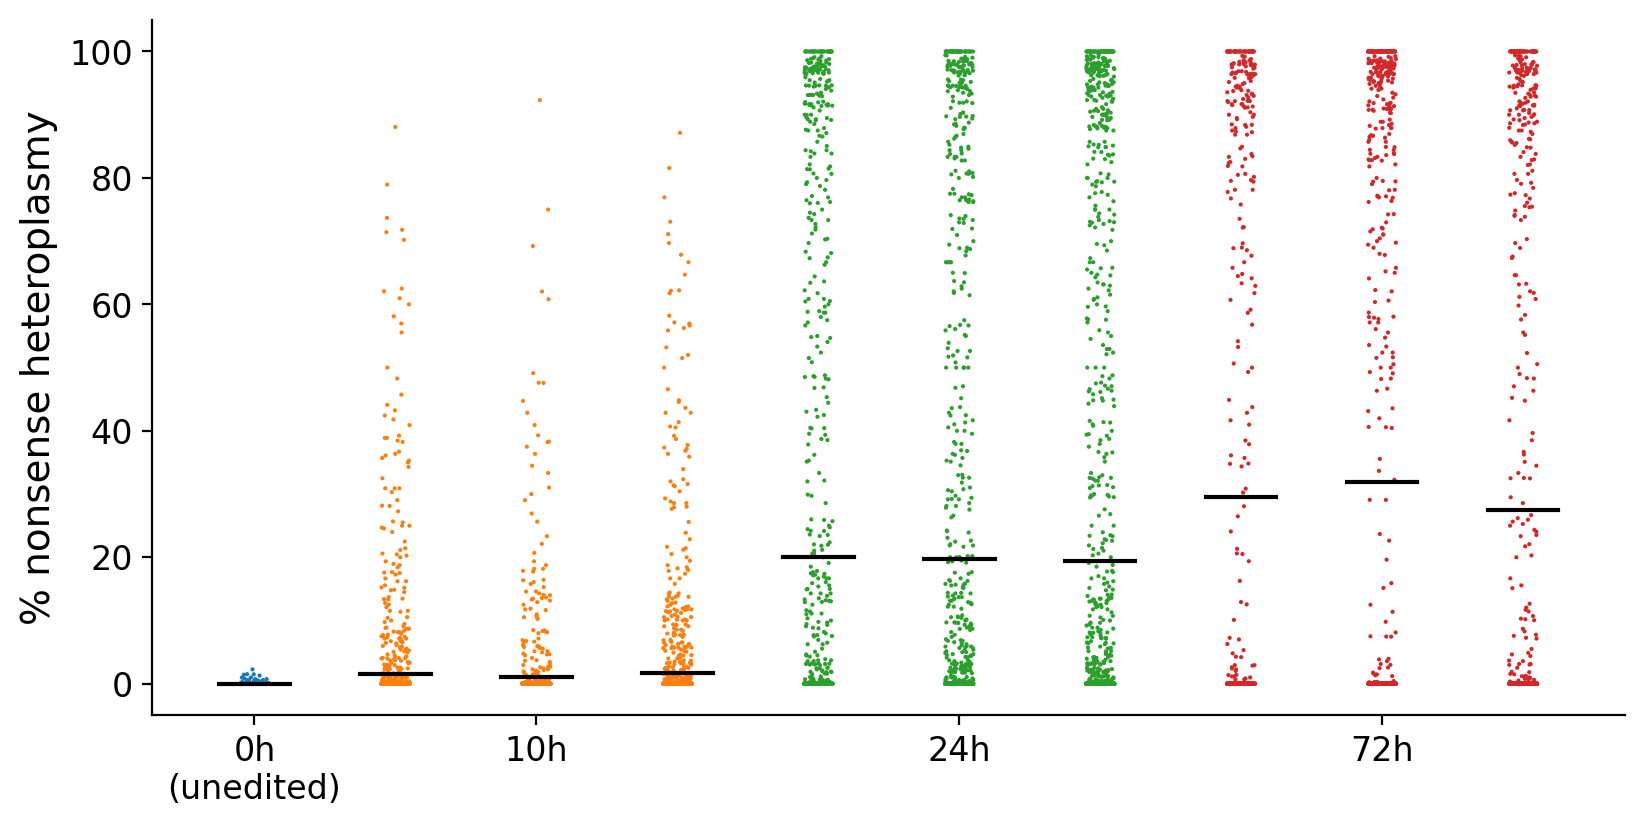

In [34]:
cmap = matplotlib.cm.get_cmap('tab10')
xorder = ['bc1_unedited', 'bc1_10h_rep1', 'bc1_10h_rep2', 'bc1_10h_rep3',
          'bc1_24h_rep1', 'bc1_24h_rep2', 'bc1_24h_rep3',
          'bc1_72h_rep1', 'bc1_72h_rep2', 'bc1_72h_rep3']
color_list = list(itertools.chain(*[[cmap(elt)]*3 for elt in [0, 0.1, 0.2, 0.3, 0.4]]))
color_list = [color_list[0]] + color_list[3:]

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,4))
#seaborn.boxplot(data=valid_cells, x='treatment', y='mtND4_het', ax=axes, order=xorder, 
#                palette=color_list, showfliers=False, showmeans=True)
for spine in ['top', 'right']:
    axes.spines[spine].set_visible(False)

seaborn.stripplot(data=valid_cells, x='condition', y='Mutant_het', dodge=True, s=1.5, order=xorder, 
                  palette=color_list, ax=axes)

meanvals = valid_cells.groupby('condition')['Mutant_het'].mean()[xorder]
for idx in range(len(xorder)):
    axes.plot([idx - 0.25, idx + 0.25], [meanvals[idx], meanvals[idx]],
              color='k', zorder=100, label='mean het estimate')

axes.set_xlabel('')
axes.set_ylabel('% nonsense heteroplasmy', fontsize=14)
axes.set_xticks([0,2,5,8])
axes.set_xticklabels(['0h\n(unedited)', '10h', '24h', '72h'], fontsize=12)
axes.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
axes.set_yticklabels(['0', '20', '40', '60', '80', '100'], fontsize=12)

#for patch in axes.artists:
#    r, g, b, a = patch.get_facecolor()
#    patch.set_facecolor((r, g, b, 0))
#    patch.set_edgecolor((r, g, b, 1))
    
#axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
fig.savefig('./editing_dynamics_strip_plot.pdf', bbox_inches='tight')
fig.tight_layout()